In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
# from keras.preprocessing.image import load_img

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Check GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Activation, Dropout, Dense, GlobalAveragePooling2D
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

In [5]:
data_path = "./train_800"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])

In [6]:
data_list = pd.DataFrame({})
data_list['img_path'] = x_data_list
data_list['label'] = y_data_list

In [7]:
data_list.head(3)

,img_path,label
0,Gray_Hair_800/7efaec9350d844d7.png,Gray_Hair_800
1,Gray_Hair_800/9dcb4f3374e14094.png,Gray_Hair_800
2,Gray_Hair_800/8df6ddb8c31041c6.png,Gray_Hair_800


In [8]:
data_list['label'] = data_list['label'].map(lambda x: x.rstrip('_800'))

In [9]:
data_list

,img_path,label
0,Gray_Hair_800/7efaec9350d844d7.png,Gray_Hair
1,Gray_Hair_800/9dcb4f3374e14094.png,Gray_Hair
2,Gray_Hair_800/8df6ddb8c31041c6.png,Gray_Hair
3,Gray_Hair_800/7ec0e40a5d7a40e6.png,Gray_Hair
4,Gray_Hair_800/3e1e952d54a54c6a.png,Gray_Hair
...,...,...
4795,Blond_Hair_800/0eb3018b8f3c4036.png,Blond_Hair
4796,Blond_Hair_800/1a6f0215fd6243c4.png,Blond_Hair
4797,Blond_Hair_800/0f2d42fe3d674f9c.png,Blond_Hair
4798,Blond_Hair_800/1e3b1a551553427c.png,Blond_Hair


In [10]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_list,
                                         test_size=0.1,
                                         random_state=42,
                                         stratify=data_list['label'].values)

In [11]:
num_class = len(data_list['label'].unique())
img_size = 224
batch_size = 32

# 模型訓練

In [12]:
from tensorflow.keras.applications.resnet import (ResNet50, preprocess_input)

In [13]:
resnet_model = ResNet50(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(resnet_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=resnet_model.inputs, outputs=outputs)

In [14]:
resnet_model.trainable = True

# trainable_layer = 3
# for layer in resnet_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

In [15]:
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [16]:
batch_size = 32
num_steps = len(train_list) // batch_size + 1
num_epochs = 10

In [17]:
train_datagen = ImageDataGenerator(
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input
                                  )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=test_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

# 用在不知道 label 的資料讀取上
# test_generator = test_datagen.flow_from_dataframe(
#                                                     dataframe=test_list,
#                                                     directory=data_path,
#                                                     x_col="img_path",
#                                                     target_size=img_shape,
#                                                     batch_size=batch_size,
#                                                     class_mode=None,
#                                                     shuffle=False)


Found 4320 validated image filenames belonging to 6 classes.
Found 480 validated image filenames belonging to 6 classes.


In [19]:
model_dir = 'model-logs/resnet50'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [20]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

Epoch 1/10
136/136 [==============================] - 142s 1s/step - loss: 1.3351 - accuracy: 0.4903 - val_loss: 0.7699 - val_accuracy: 0.7250
Epoch 2/10
136/136 [==============================] - 72s 528ms/step - loss: 0.6749 - accuracy: 0.7505 - val_loss: 0.5927 - val_accuracy: 0.7875
Epoch 3/10
136/136 [==============================] - 72s 526ms/step - loss: 0.4991 - accuracy: 0.8194 - val_loss: 0.5508 - val_accuracy: 0.8000
Epoch 4/10
136/136 [==============================] - 70s 511ms/step - loss: 0.4140 - accuracy: 0.8449 - val_loss: 0.5509 - val_accuracy: 0.7979
Epoch 5/10
136/136 [==============================] - 71s 526ms/step - loss: 0.3573 - accuracy: 0.8688 - val_loss: 0.5440 - val_accuracy: 0.8042
Epoch 6/10
136/136 [==============================] - 71s 526ms/step - loss: 0.2895 - accuracy: 0.8920 - val_loss: 0.5488 - val_accuracy: 0.8167
Epoch 7/10
136/136 [==============================] - 70s 513ms/step - loss: 0.2677 - accuracy: 0.9067 - val_loss: 0.5525 - val_accu

In [23]:
loss, acc = model.evaluate_generator(valid_generator, verbose=2)

15/15 - 2s - loss: 0.5852 - accuracy: 0.8146


In [24]:
y_pred = model.predict_generator(valid_generator)
y_pred = y_pred.argmax(-1)

In [25]:
y_test = valid_generator.classes
class_name = valid_generator.class_indices
class_names = np.array([each for each in class_name.keys()])

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8145833333333333
[[74  0  0  0  5  1]
 [ 0 59  0 11  0 10]
 [ 0  0 71  7  1  1]
 [ 0  5  3 65  2  5]
 [ 2  2  3  1 68  4]
 [ 2  6  4 10  4 54]]


Text(0.5, 1, 'Confusion Matrix')

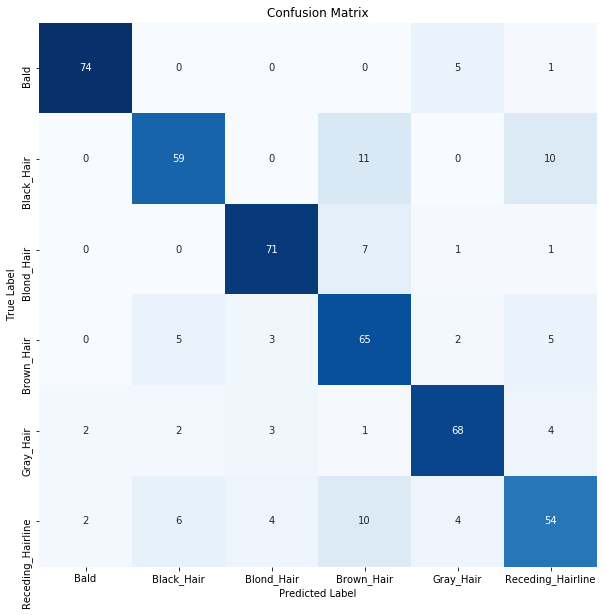

In [27]:
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

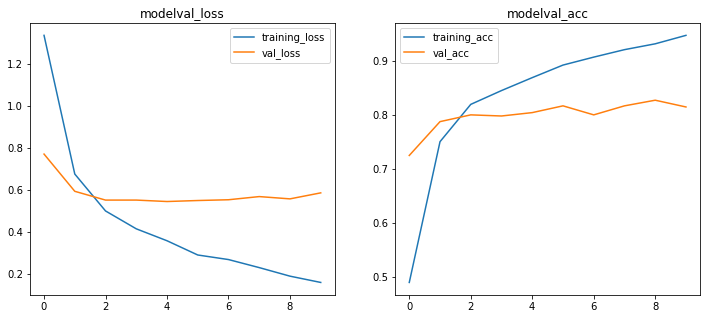

In [28]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model'+eachy)
plt.show()

### Testset output method 1

In [29]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory("testset/", target_size=(224, 224), class_mode=None, shuffle=False)
test_generator.class_indices

Found 3006 images belonging to 2 classes.


{'.ipynb_checkpoints': 0, 'testset_hair': 1}

In [30]:
pred = model.predict(test_generator).argmax(-1)
print(type(pred))

<class 'numpy.ndarray'>


In [42]:
# test_generator.filenames

In [44]:
id = []
for p in test_generator.filenames:
    id.append(os.path.splitext(p)[0][13:]+'.png')
# print(p)
print(os.path.splitext(p)[0][13:])


.ipynb_checkpoints/a1d50265a7114e18-checkpoint


In [45]:
import pandas as pd
import datetime

res = pd.DataFrame()
res["fileName"] = id
res["class"] = pred

now = datetime.datetime.now().strftime("%Y-%b-%d-%I:%M")
res.to_csv(f'predictions/{now}.csv', index=False)

In [46]:
result_cut = pd.read_csv(f'predictions/{now}.csv')

In [47]:
result_cut.tail(15)

,fileName,class
2991,a6ace066d1334a4d.png,0
2992,a6edf5bee0794594.png,0
2993,a6f272588b2440ed.png,0
2994,a82f41c9378a4577.png,0
2995,a84ac249fe5a4321.png,0
2996,a8c72d2e01904f03.png,0
2997,a8cf1a21ccf648e5.png,0
2998,a917be9cff72423b.png,0
2999,a933eb7a3a044018.png,0
3000,.ipynb_checkpoints/0004a19b4e3340fe-checkpoint...,5


In [48]:
result_cut = result_cut[:3000]

In [49]:
result_cut.to_csv(f'predictions/{now}.csv', index=False)